In [1]:
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import os
import numpy as np
from matplotlib.ticker import MultipleLocator

import utils as ut

2025-08-07 11:20:16.160200: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 11:20:16.197708: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-07 11:20:16.198304: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-07 11:20:19.047883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# function to perform analysis of efficiency results
def analyzeResults(pt, pt_bins, results):
    effs, eff_errs = [], []
    # loop over the pT bins
    for i in range(len(pt_bins) - 1):
        in_bin_extracted = (pt >= pt_bins[i]) & (pt < pt_bins[i+1])
        N = np.sum(in_bin_extracted)
        if np.sum(in_bin_extracted) > 0:
            # Check how many were correctly labeled as high pT (label 0)
            labeled_high_pt = (results[in_bin_extracted] == 0)
            npass = np.sum(labeled_high_pt)
            eff = npass / N
            eff_err = efficiency_error(eff, N)
            # save
            effs.append(eff)
            eff_errs.append(eff_err)
        else:
            effs.append(0)
            eff_errs.append(0)
    return np.array(effs), np.array(eff_errs)
    
# efficiency error calculation
def efficiency_error(eff, N):
    ''' 
    See section 2.2.1 https://lss.fnal.gov/archive/test-tm/2000/fermilab-tm-2286-cd.pdf
    eff = estimate of the efficiency
    N = sample size
    '''
    return np.sqrt(eff * (1 - eff) / N)

In [18]:
dir = "/asic/projects/C/CMS_PIX_28/abadea/working/filter/test/tmp/400_1600_2400"

# load the final results
pt = np.load(os.path.join(dir, "pts.npy"))
ylocals = np.load(os.path.join(dir, "ylocals.npy"))
clslabels = np.load(os.path.join(dir, "clslabels.npy"))
keras_predictions = np.load(os.path.join(dir, "keras_predictions.npy"))
keras_predictions = np.argmax(keras_predictions, axis=1)
qkeras_predictions = np.load(os.path.join(dir, "qkeras_predictions.npy"))
qkeras_predictions = np.argmax(qkeras_predictions, axis=1)
asic_predictions = np.load("/asic/projects/C/CMS_PIX_28/dshekar/CMSPIX28_DAQfirstTestStand/lab_analysis/final_results.npy")

Text(1, 0, 'y-local [mm]')

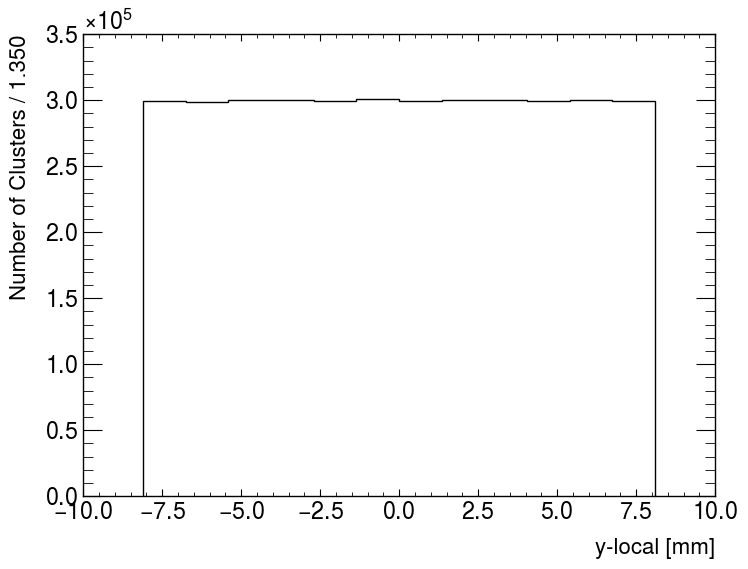

In [20]:
# plot ylocals
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(-8.1, 8.1, 13)
bw = bins[1] - bins[0]
ax.hist(ylocals, bins=bins, histtype='step', color='black')
ax.set_ylabel(f"Number of Clusters / {bw:.3f}", fontsize=16)
ax.set_xlabel("y-local [mm]", fontsize=16)


Bin 6: 299739 entries in ylocal range [0.00, 1.35)
(7825,) 299739


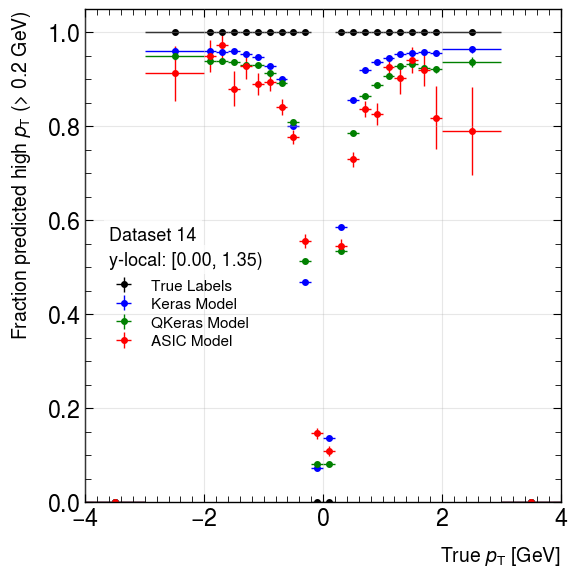

In [25]:
from PyPDF2 import PdfMerger

# Create bins for true pT values from -4 to 4
bins_pos = np.unique(np.concatenate([
    np.linspace(0, 1, 5, endpoint=False),
    np.linspace(1, 2, 5, endpoint=False),
    np.linspace(2, 4, 3, endpoint=True)
]))
bins_neg = -1 * bins_pos[::-1]
pt_bins = np.unique(np.concatenate([bins_neg, bins_pos]))
bin_centers = (pt_bins[:-1] + pt_bins[1:]) / 2
bin_widths = np.diff(pt_bins)

# binNumberList = range(len(bins) - 1) # full range
binNumberList = [6] # just the 0th bin, as chosen by Giuseppe
for bin_number in binNumberList:
    
    # Select the range of the i-th bin of ylocal
    ylocal_min = bins[bin_number]
    ylocal_max = bins[bin_number + 1]
    # interested_range = (ylocal_min, ylocal_max)
    mask = (ylocals >= ylocal_min) & (ylocals < ylocal_max)
    print(f"Bin {bin_number}: {mask.sum()} entries in ylocal range [{ylocal_min:.2f}, {ylocal_max:.2f})")
    
    # apply the mask
    pt_bin = pt[mask]
    clslabels_bin = clslabels[mask]
    keras_predictions_bin = keras_predictions[mask]
    qkeras_predictions_bin = qkeras_predictions[mask]

    # asic results
    true_res_bin = analyzeResults(pt_bin, pt_bins, clslabels_bin)
    keras_res_bin = analyzeResults(pt_bin, pt_bins, keras_predictions_bin)
    qkeras_res_bin = analyzeResults(pt_bin, pt_bins, qkeras_predictions_bin)
    asic_res_bin = analyzeResults(pt_bin[:asic_predictions.shape[0]], pt_bins[:asic_predictions.shape[0]], asic_predictions)
    print(asic_predictions.shape, mask.sum())

    # Create the plot
    fig, ax = plt.subplots(figsize=(6,6))

    # plot error bars
    ax.errorbar(bin_centers, true_res_bin[0], xerr=bin_widths/2, yerr=true_res_bin[1], fmt='o', linewidth=1, markersize=4, color="black", label="True Labels")
    ax.errorbar(bin_centers, keras_res_bin[0], xerr=bin_widths/2, yerr=keras_res_bin[1], fmt='o', linewidth=1, markersize=4, color="blue", label="Keras Model")
    ax.errorbar(bin_centers, qkeras_res_bin[0], xerr=bin_widths/2, yerr=qkeras_res_bin[1], fmt='o', linewidth=1, markersize=4, color="green", label="QKeras Model")
    ax.errorbar(bin_centers, asic_res_bin[0], xerr=bin_widths/2, yerr=asic_res_bin[1], fmt='o', linewidth=1, markersize=4, color="red", label="ASIC Model")

    # set plot styles
    ax.set_xlabel(r'True $p_{\mathrm{T}}$ [GeV]')
    ax.set_ylabel(r'Fraction predicted high $p_{\mathrm{T}}$ (> 0.2 GeV)')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-4, 4)
    ax.tick_params(which='minor', length=4)
    ax.tick_params(which='major', length=6)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))

    ax.legend(loc='upper left', fontsize=11, bbox_to_anchor=(0, 0.5))
    # Add text for ylocal bin range
    ax.text(0.05, 0.56, f"Dataset 14", transform=ax.transAxes, fontsize=13, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.text(0.05, 0.51, f"y-local: [{ylocal_min:.2f}, {ylocal_max:.2f})", transform=ax.transAxes, fontsize=13, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.tight_layout()
    plt.show()

    # Create 'plots' directory if it doesn't exist
    os.makedirs("plots", exist_ok=True)

    # Save the current figure as a PDF in the 'plots' directory
    pdf_filename = f"plots/eff_vs_pt_ylocal_bin_{bin_number}.pdf"
    # fig.savefig(pdf_filename)

# After the loop, concatenate all PDFs into one (run this after the loop)
if len(binNumberList) > 1:
    merger = PdfMerger()
    pdf_files = [f"plots/eff_vs_pt_ylocal_bin_{i}.pdf" for i in binNumberList]
    for pdf in pdf_files:
        merger.append(pdf)
    merger.write("plots/all_eff_vs_pt_ylocal_bins.pdf")
    merger.close()
